In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler

In [3]:
## Load the entire data set
df = pd.read_csv('/Users/Daniel/Downloads/GAMA_ex.csv')
df = df[(df['logmstar'] > 0) & (df['d'].notnull())] ## removes anything that has 0 value for stellar mass (for whatever reason) or doesn't have 'd' value
df

,CATAID,Z,nQ,logmstar,dellogmstar,logage,dellogage,logtau,dellogtau,metal,delmetal,extBV,delextBV,RA,DEC,X,Y,Z.1,d,FilID
1071,14472,0.11432,4,10.57630,0.099281,9.84892,0.173313,9.61434,0.285199,0.011573,0.008694,0.263208,0.130978,211.71579,0.63936,34.058370,336.222129,3.771253,3.707450,150060.0
1079,14480,0.20018,4,10.36390,0.110768,9.77697,0.200401,9.70207,0.230663,0.016244,0.009546,0.223255,0.112565,211.66567,0.75474,58.892502,576.352904,7.632137,1.612440,150221.0
1082,14485,0.18342,5,10.85630,0.105653,9.80181,0.187472,9.54968,0.320811,0.007964,0.006806,0.174119,0.110125,211.78927,0.72757,53.031673,530.303284,6.768023,3.580060,150186.0
1083,14486,0.19952,4,10.79260,0.106621,9.75812,0.204969,9.72982,0.211443,0.011286,0.007187,0.187541,0.098846,211.82425,0.77111,57.116338,574.691761,7.773001,1.875860,150221.0
1084,14487,0.20088,4,10.08270,0.107895,9.49168,0.241306,9.78591,0.184922,0.012405,0.007280,0.078842,0.074063,211.83096,0.77553,57.419270,578.430318,7.868330,1.877050,150221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111692,747326,0.18675,4,11.47670,0.106227,9.81439,0.171897,8.99272,0.427624,0.010655,0.007496,0.118252,0.093518,213.88429,-0.04989,34.189908,541.064025,-0.472030,2.081950,150008.0
111729,748601,0.19344,4,10.21610,0.107744,9.78807,0.191085,9.67606,0.250536,0.009743,0.007355,0.209148,0.107776,213.36304,0.36993,40.448833,559.231397,3.620104,0.671291,150145.0
111735,748610,0.12744,4,10.51020,0.096180,9.85412,0.160613,9.21082,0.463249,0.012617,0.008271,0.127842,0.112837,213.95954,0.25653,23.178537,374.623081,1.680548,0.087637,150051.0
111810,750269,0.19007,4,9.30235,0.108101,9.06462,0.245388,9.73364,0.226729,0.008252,0.005942,0.049608,0.047308,217.71133,0.72954,-2.032609,551.095874,7.017423,2.178990,150035.0


In [4]:
# reduces dataframe to 7 features for ~10k galaxies, including the dist. to filament

# Z : heliocentric redshift            # logmstar : stellar mass 
# logage : age of galaxy               # logtau : timescale parameter for star formation rate 
# metal : metallicity abundance 
# extBV: dust extinction or absorption along the line of sight
# d : galaxy's orthogonal distance to it's nearest filament 

metric_names = ['Z', 'logmstar', 'logage', 'logtau', 'metal', 'extBV', 'd']
npdf = df[metric_names]
npdf 

,Z,logmstar,logage,logtau,metal,extBV,d
1071,0.11432,10.57630,9.84892,9.61434,0.011573,0.263208,3.707450
1079,0.20018,10.36390,9.77697,9.70207,0.016244,0.223255,1.612440
1082,0.18342,10.85630,9.80181,9.54968,0.007964,0.174119,3.580060
1083,0.19952,10.79260,9.75812,9.72982,0.011286,0.187541,1.875860
1084,0.20088,10.08270,9.49168,9.78591,0.012405,0.078842,1.877050
...,...,...,...,...,...,...,...
111692,0.18675,11.47670,9.81439,8.99272,0.010655,0.118252,2.081950
111729,0.19344,10.21610,9.78807,9.67606,0.009743,0.209148,0.671291
111735,0.12744,10.51020,9.85412,9.21082,0.012617,0.127842,0.087637
111810,0.19007,9.30235,9.06462,9.73364,0.008252,0.049608,2.178990


### First passthrough try just ***autoencoder*** to reduce dimensionality

In [5]:
# convert to array & scale using StandardScaler
x_train = npdf.to_numpy()
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

In [6]:
# This is the dimension of the original space  (7 in our case right now)
input_dim = 7

# This is the dimension of the latent space (encoding space)  -- up to use to choose latent space dimensionality
latent_dim = 3

encoder = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(latent_dim, activation='relu')
])

decoder = Sequential([
    Dense(64, activation='relu', input_shape=(latent_dim,)),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(input_dim, activation=None)
])

In [7]:
# stitch up the encoder and the decoder models into a single model, the autoencoder 
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

1/1 [==============================] - 0s 11ms/step


/var/folders/nd/klv0c43973gc4llkjgc9276m0000gp/T/ipykernel_3827/88604628.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[i].set_xticklabels(metric_names)


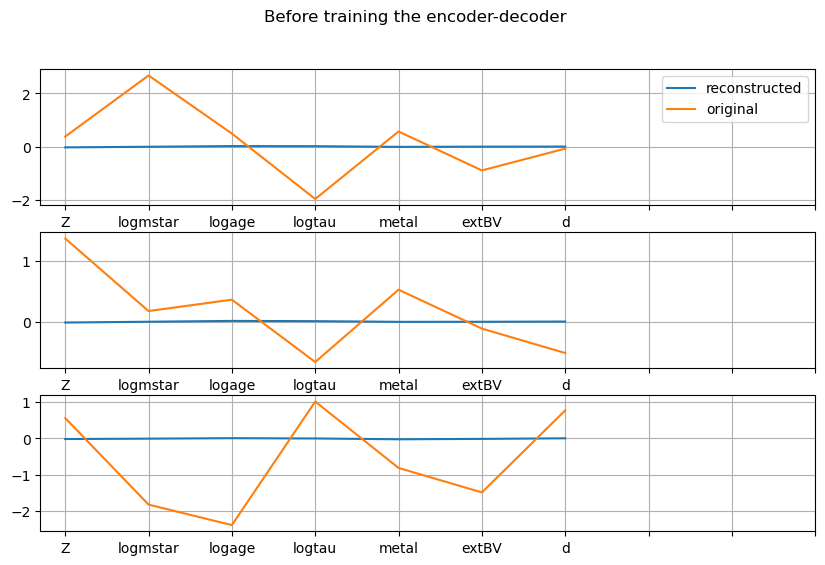

In [9]:
# Example of autoencoder NOT yet trained -- should make no sense / be terrible!

def plot_orig_vs_recon(title='', n_samples=3):
    fig = plt.figure(figsize=(10,6))
    plt.suptitle(title)
    for i in range(3):
        plt.subplot(3, 1, i+1)
        idx = random.sample(range(x_train.shape[0]), 1)
        plt.plot(autoencoder.predict(x_train[idx]).squeeze(), label='reconstructed' if i == 0 else '')
        plt.plot(x_train[idx].squeeze(), label='original' if i == 0 else '')
        fig.axes[i].set_xticklabels(metric_names)
        plt.xticks(np.arange(0, 10, 1))
        plt.grid(True)
        if i == 0: plt.legend();

plot_orig_vs_recon('Before training the encoder-decoder')

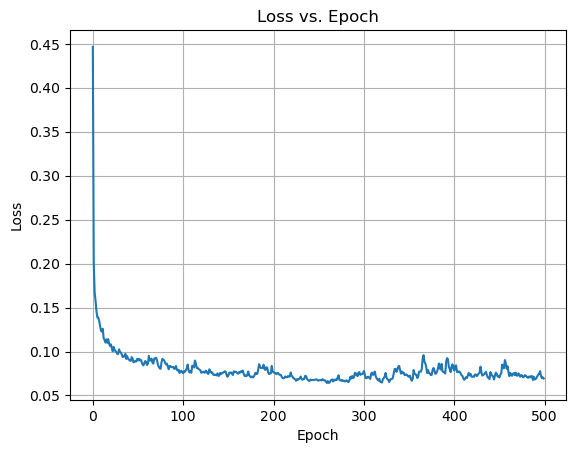

In [8]:
# Now train the autoencoder
model_history = autoencoder.fit(x_train, x_train, epochs=500, batch_size=32, verbose=0)
# epochs - number of iterations of training; using all training data at once(ie. # of passes of algorithm); loss is in MSE
plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

1/1 [==============================] - 0s 10ms/step


/var/folders/nd/klv0c43973gc4llkjgc9276m0000gp/T/ipykernel_8614/88604628.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[i].set_xticklabels(metric_names)


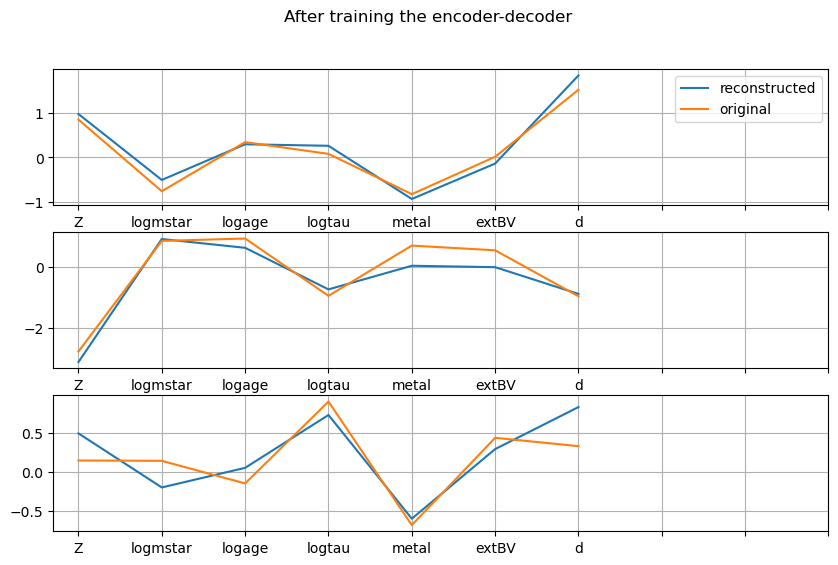

In [9]:
# plots the original vs reconstructed data set AFTER training autoencoder 
plot_orig_vs_recon('After training the encoder-decoder')

Text(0.5, 0, 'Latent Dimension 3')

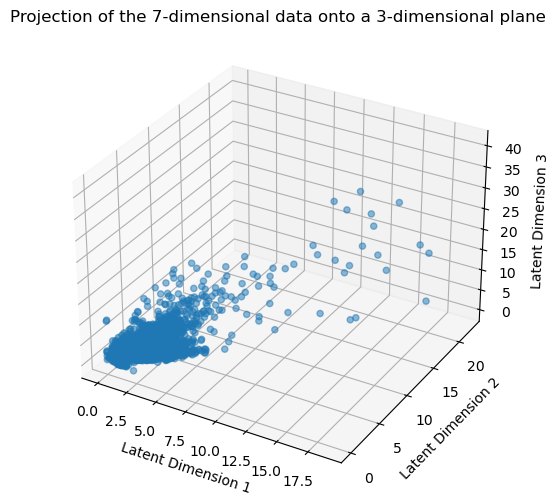

In [12]:
# plots the 3 dimensions of the latent space

encoded_x_train = encoder(x_train)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.scatter3D(encoded_x_train[:, 0], encoded_x_train[:, 1],encoded_x_train[:,2], alpha = 0.5)
plt.title('Projection of the 7-dimensional data onto a 3-dimensional plane')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

### Run latent space through Eben's ***Neural Network***

In [37]:
# import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
def compare_lists(list_a,list_b):
  ''' 
  This function takes as inputs two lists or numpy arrays of the same size, and returns 
  the percentage of how many rows match between them.
  '''
  array_a=np.array(list_a)
  array_b=np.array(list_b)
  if (array_a).shape!=array_b.shape:
    print("Error: Input lists are not the same shapes.")
    return
  if array_a.ndim==1:
    array_a=array_a.reshape(len(array_a),1)
    array_b=array_b.reshape(len(array_b),1)
  array_a=np.around(array_a)
  array_b=np.around(array_b)
  return np.sum([ all(x==y) for (x,y) in zip(array_a, array_b)])/len(array_a)

In [39]:
# turn encoded_x_train (latent space) into numpy array 
arr = np.array(encoded_x_train)
np.shape(arr)

(10132, 3)

In [40]:
# convert the two dimensions/features of LS into dataframe
ls = pd.DataFrame(arr, columns = ['Feat1', 'Feat2', 'Feat3'])
ls

,Feat1,Feat2,Feat3
0,3.290008,2.209494,2.530535
1,0.933873,0.698310,1.230520
2,1.277428,0.211857,0.997227
3,0.647667,0.541067,0.813714
4,0.519348,1.247115,1.552109
...,...,...,...
10127,3.097667,0.253407,1.414348
10128,0.764009,0.667730,0.704908
10129,2.540730,0.966960,0.913709
10130,0.293507,2.464494,2.785721


In [41]:
ls['Feat3'].describe()

count    10132.000000
mean         1.271242
std          0.745222
min          0.000000
25%          0.793052
50%          1.082976
75%          1.591735
max         13.938119
Name: Feat3, dtype: float64

In [42]:
d = np.array(df['d'])
d

array([3.70745  , 1.61244  , 3.58006  , ..., 0.0876374, 2.17899  ,
       0.284429 ])

In [43]:
# add the original distances to latent space dataframe
ls.insert(3,'d', d, True)
ls

,Feat1,Feat2,Feat3,d
0,3.290008,2.209494,2.530535,3.707450
1,0.933873,0.698310,1.230520,1.612440
2,1.277428,0.211857,0.997227,3.580060
3,0.647667,0.541067,0.813714,1.875860
4,0.519348,1.247115,1.552109,1.877050
...,...,...,...,...
10127,3.097667,0.253407,1.414348,2.081950
10128,0.764009,0.667730,0.704908,0.671291
10129,2.540730,0.966960,0.913709,0.087637
10130,0.293507,2.464494,2.785721,2.178990


In [55]:
# create separate train and test splits for LS dataframe 
condition = npdf['d'].notna()

fil_train_df, fil_test_df = train_test_split(ls, test_size=0.2, random_state=42)

In [56]:
xinput_train = fil_train_df.loc[:,['Feat1', 'Feat2','Feat3']].values  # Training data input invariants.

output_train = fil_train_df.loc[:,'d'].values   # Training data output invariant.

input_test = fil_test_df.loc[:,['Feat1', 'Feat2','Feat3']].values  # Test data input invariants.

output_test = fil_test_df.loc[:,'d'].values   # Test data output invariant.

In [57]:
filament_predictor = keras.Sequential(
    [
        layers.Input(shape=(3,)),  # shape = number of dimensions in train 
        layers.Dense(100, activation = "elu"),
        layers.Dense(100, activation = "relu"),
        layers.Dense(100, activation = "elu"),
        layers.Dense(100, activation = "relu"),
        layers.Dense(100, activation = "relu"),
        layers.Dense(1),
    ]
)

filament_predictor.compile(optimizer=tf.optimizers.Adam(),loss = 'mean_squared_error')

In [58]:
model_history = filament_predictor.fit(xinput_train, output_train, epochs = 1000, validation_split = 0.2, verbose = 1)

Epoch 1/1000
203/203 [==============================] - 1s 1ms/step - loss: 0.7157 - val_loss: 0.2513
Epoch 2/1000
203/203 [==============================] - 0s 771us/step - loss: 0.1743 - val_loss: 0.1476
Epoch 3/1000
203/203 [==============================] - 0s 749us/step - loss: 0.1271 - val_loss: 0.0936
Epoch 4/1000
203/203 [==============================] - 0s 759us/step - loss: 0.1019 - val_loss: 0.0805
Epoch 5/1000
203/203 [==============================] - 0s 754us/step - loss: 0.0890 - val_loss: 0.1322
Epoch 6/1000
203/203 [==============================] - 0s 769us/step - loss: 0.0981 - val_loss: 0.0878
Epoch 7/1000
203/203 [==============================] - 0s 748us/step - loss: 0.0832 - val_loss: 0.0858
Epoch 8/1000
203/203 [==============================] - 0s 739us/step - loss: 0.0831 - val_loss: 0.0905
Epoch 9/1000
203/203 [==============================] - 0s 744us/step - loss: 0.0898 - val_loss: 0.1065
Epoch 10/1000
203/203 [==============================] - 0s 740us/

In [59]:
predicted_distance = filament_predictor.predict(input_test).reshape(len(input_test),)   # These are the predictions our neural network makes

compare_lists(predicted_distance, output_test)  

64/64 [==============================] - 0s 406us/step


0.8485446472619635

In [60]:
predicted_distance.shape # great, shape matches size of test set

(2027,)

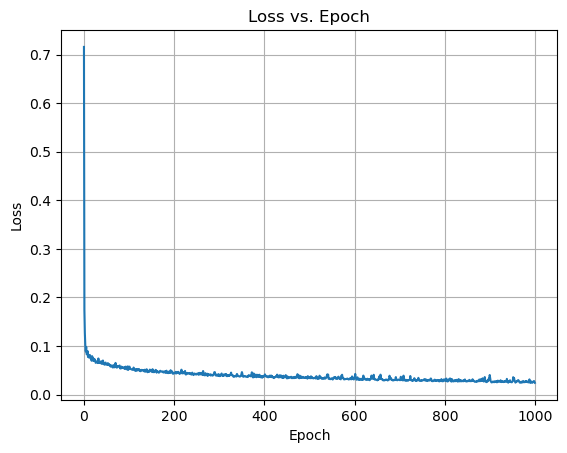

In [61]:
plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)